<a href="https://colab.research.google.com/github/jaskcodes/NMF-Music-Project/blob/main/NMF_Music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Creation and Decomposition through Non-negative Matrix Factorization

## Imports

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import IPython.display as ipd
import soundfile as sf

## Load Audio

### Load the signal, $x$:

In [ ]:
# Get sound file represented as a floating point time series
# x, sr = librosa.load('cha-cha-groove.mp3', offset = 12.0, duration = 10.0)
x, sr = librosa.load('Albums-I_Like_It2-09.wav', offset = 3.0, duration = 10.0)

In [ ]:
sr

22050

In [ ]:
len(x)

220500

In [ ]:
x, sr = librosa.load('Albums-Latin_Jam2-01.wav', offset = 3.0, duration = 10.0)


### Play audio

In [ ]:
ipd.Audio(x, rate=sr)

### Compute STFT $X$, and separate into magnitude and phase:

In [ ]:
X = librosa.stft(x)
X_mag, X_phase = librosa.magphase(X)

### Visualize Audio

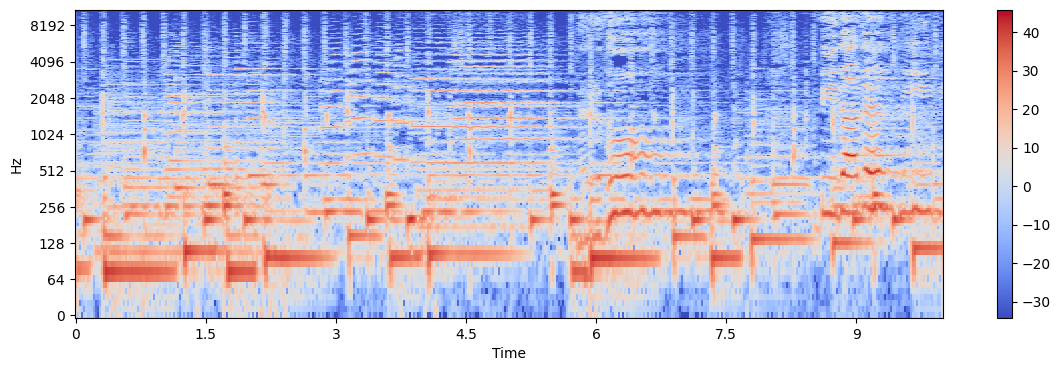

In [ ]:
X_db = librosa.amplitude_to_db(X_mag)
plt.figure(figsize=(14, 4)) # figure size in inches
librosa.display.specshow(X_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

## NMF Algorithms

### Loss Functions

#### Euclidean Distance
Minimize $||V - WH||^2 = \sum_{ij} (V_{ij} - (WH)_{ij})^2$ with respect to W and H, subject to the constraints $W, H \geq 0$.

#### Divergence
Minimize $D(V || WH) = \sum_{ij} (V_{ij} \log{\frac{V_{ij}}{(WH)_{ij}}} - V_{ij} + (WH)_{ij})$ with respect to W and H, subject to the constraints $W, H \geq 0$.

### Multiplicative Update Functions

In [ ]:
def euclidean_nmf(V, n_components, n_iter = 1000):
  n, p = V.shape
  W = np.random.random((n, n_components))
  H = np.random.random((n_components, p))

  for i in range(n_iter):
    H_new = np.multiply(H, np.divide(W.T @ V, W.T @ W @ H))
    W_new = np.multiply(W, np.divide(V @ H.T, W @ H @ H.T))

    H = H_new
    W = W_new

  return W, H

def divergence_nmf(V, n_components, n_iter = 1000):
  n, p = X.shape
  W = np.random.random((n, n_components))
  H = np.random.random((n_components, p))

  for i in range(n_iter):
    W_H = W @ H

    H_new = np.zeros(H.shape)
    for a in range(H.shape[0]):
      for b in range(H.shape[1]):
        H_new[a,b] = H[a,b] *np.sum(np.divide(np.multiply(W[:,a],V[:,b]), W_H[:,b]))/np.sum(W[:,a])

    W_new = np.zeros(W.shape)
    for a in range(W.shape[0]):
      for b in range(W.shape[1]):
        W_new[a,b] = W[a,b] * np.sum(np.divide(np.multiply(H[b],V[a]), W_H[a]))/np.sum(H[b])

    H = H_new
    W = W_new


  return W, H

### Run Algorithms

In [ ]:
# Get W and H matrices
n_components = 6

W_base, H_base = librosa.decompose.decompose(X_mag, n_components=n_components, sort=True, )
# W_ H_ = librosa.decompose.decompose(X_mag, ..., transformer=eucliedan_nmf)
W_euclidean, H_euclidean = euclidean_nmf(X_mag, n_components=n_components, n_iter=500)
W_divergence, H_divergence = divergence_nmf(X_mag, n_components=n_components, n_iter=500)

### Reconstruct Audio

In [ ]:
# Re-create the STFT from all NMF components.
Y_base = np.dot(W_base, H_base)*X_phase
Y_euclidean = np.dot(W_euclidean, H_euclidean)*X_phase
Y_divergence = np.dot(W_divergence, H_divergence)*X_phase

In [ ]:
# Transform the STFT into the time domain.
recon_signal_base = librosa.istft(Y_base, length=len(x))
recon_signal_euclidean = librosa.istft(Y_euclidean, length=len(x))
recon_signal_divergence = librosa.istft(Y_divergence, length=len(x))

### Play Original and Reconstructed Audio

In [ ]:
# Original
ipd.Audio(x, rate=sr)

In [ ]:
# Librosa Decompose
ipd.Audio(recon_signal_base, rate=sr)

In [ ]:
# Euclidean Decompose
ipd.Audio(recon_signal_euclidean, rate=sr)

In [ ]:
# Divergence Decompose
ipd.Audio(recon_signal_divergence, rate=sr)

## Visualize Results

In [ ]:
with open('W_base_ILI.npy', 'wb') as f:
  np.save(f, W_base)
with open('H_base_ILI.npy', 'wb') as f:
  np.save(f, H_base)


In [ ]:
# Our data is 1025x6
print("X_mag", X_mag.shape)
print("W_base", W_base.shape, "H_base", H_base.shape)

print(np.min(W_base))
print(np.max(W_base))

cmap='viridis'

def W_colormesh():
  # Our range e
  plt.pcolormesh(W_base, cmap=cmap, vmin=0, vmax=2)
  plt.show()

def W_graphs():
  fig, axs = plt.subplots(1, 6)

  for i,ax in enumerate(axs.flat):
    ax.plot(W_base[:,i])

  plt.show()

def H_colormesh():
  plt.pcolormesh(H_base, cmap=cmap) #, cmap=mpl_colors.ListedColormap(["white", "skyblue", "darkblue"]))
  plt.show()

def H_graphs():
  fig, axs = plt.subplots(2, 3)
  for i, ax in enumerate(axs.flat):
    ax.plot(H_base[i])

  plt.show()

W_colormesh()
H_graphs()
# H_colormesh()

NameError: ignored

# Music Mosaic

Take the components of "I Like It", from 0:03 to 0:13, and combine it with the temporal envelopes of "Latin Jam 2", from 0:08 to 0:18.

In [ ]:
def music_mosaic(soundwave_w: str, soundwave_h: str):
    sr = 22050
    # Mix and match the two tracks
    # W and phase from I Like It
    with open(f"{soundwave_w}-W_base.npy", "rb") as f:
        W = np.load(f)

    # ?
    with open(f"{soundwave_w}-X_phase.npy", "rb") as f:
        X_phase = np.load(f)
    with open(f"{soundwave_w}-x.npy", "rb") as f:
        x = np.load(f)

    # H from Latin Jam
    with open(f"{soundwave_h}-H_base.npy", "rb") as f:
        H = np.load(f)

    # Recreate
    Y_base = np.dot(W, H)*X_phase
    recon_signal_base = librosa.istft(Y_base, length=len(x))
    sf.write(f"{soundwave_w}-AND-{soundwave_h}.wav",
             recon_signal_base, samplerate=sr)

    # Audio: NOT WORKING
    # recon_signal_mag, recon_signal_phase = librosa.magphase(recon_signal_base)
    # recon_signal_db = librosa.amplitude_to_db(recon_signal_mag)
    # plt.figure(figsize=(14, 4))  # figure size in inches
    # librosa.display.specshow(recon_signal_db, sr=sr,
    #                          x_axis='time', y_axis='log')
    # plt.colorbar()
    # plt.savefig(f"{soundwave_w}-AND-{soundwave_h}-audio.png")


In [ ]:
W_base[:,]